In [1]:
import os
import sys

#Import config file. Update config.py according to your environment
import config

import pandas as pd
import numpy as np

from Rakuten_preprocessing import Rakuten_img_path

from src.text.classifiers import TFbertClassifier
from src.image.classifiers import ImgClassifier
from src.multimodal.classifiers import TFmultiClassifier

from src.utils.load import load_classifier

from src.utils.visualize import deepCAM, plot_weighted_text

import cv2

/home/jul/anaconda3/envs/Rakuten/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

2024-03-18 05:34:21.903985: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-18 05:34:21.926783: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-18 05:34:21.926806: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-18 05:34:21.927502: E external/local_xla/xla/stream_execut

## Loading the data

In [2]:
data_train = pd.read_csv(os.path.join(config.path_to_data, 'df_train_index.csv'))
data_train['testset'] = False
data_test = pd.read_csv(os.path.join(config.path_to_data, 'df_test_index.csv'))
data_test['testset'] = True
data = pd.concat([data_train, data_test], axis=0).reset_index(drop=True)

#merging text into token column
colnames = ['designation_translated', 'description_translated'] #['designation', 'description']#
data['tokens'] = data[colnames].apply(lambda row: ' '.join(s.lower() for s in row if isinstance(s, str)), axis=1)

#path to images into img_path column
data['img_path'] = Rakuten_img_path(img_folder=config.path_to_images,
                             imageid=data['imageid'], productid=data['productid'], suffix='_resized')

In [3]:
#labels of encoded classes
class_labels = data.groupby('prdtypedesignation')['prdtypeindex'].first().reset_index()
class_labels.index = class_labels['prdtypeindex']
class_labels = class_labels.drop(columns='prdtypeindex').sort_index()

## Loading the model

In [4]:
# clf_resnet = load_classifier('image/ResNet152')
# clf_vit = load_classifier('image/vit_b16')
# clf_bert = load_classifier('text/camembert-base-ccnet')
clf_fusion = load_classifier('fusion/camembert-base-vit_b16_TF6_att12')

2024-03-18 05:34:31.866588: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-18 05:34:31.886882: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-18 05:34:31.886928: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-18 05:34:31.889126: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-18 05:34:31.889172: I external/local_xla/xla/stream_executor

loading weights for multimodal model from  fusion/camembert-base-vit_b16_TF6_att12


## Instantiating the deepCAM with the classifier

In [5]:
icam = deepCAM(clf_fusion)

All model checkpoint layers were used when initializing TFCamembertModel.

All the layers of TFCamembertModel were initialized from the model checkpoint at /mnt/c/Users/justj/Documents/DST/RakutenProject/models/base_models/camembert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertModel for predictions without further training.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Compute Masks for a given entry

In [26]:
#Pick some data
idx = 0
image = cv2.imread(data['img_path'][idx])
text = data['tokens'][idx]
X = {'text': text, 'image': image}

#Compute masks and maasked inputs
icam.computeMaskedInput(X, min_factor=0.0);

1/1 [==============================] - 1s 1s/step


## Plot the original inputs and the deepCAM masked inputs

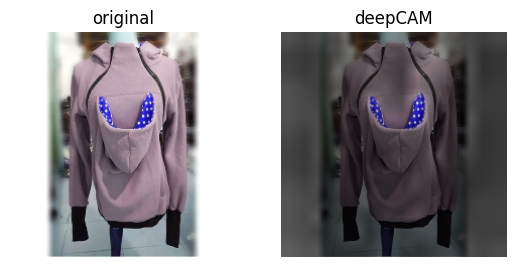

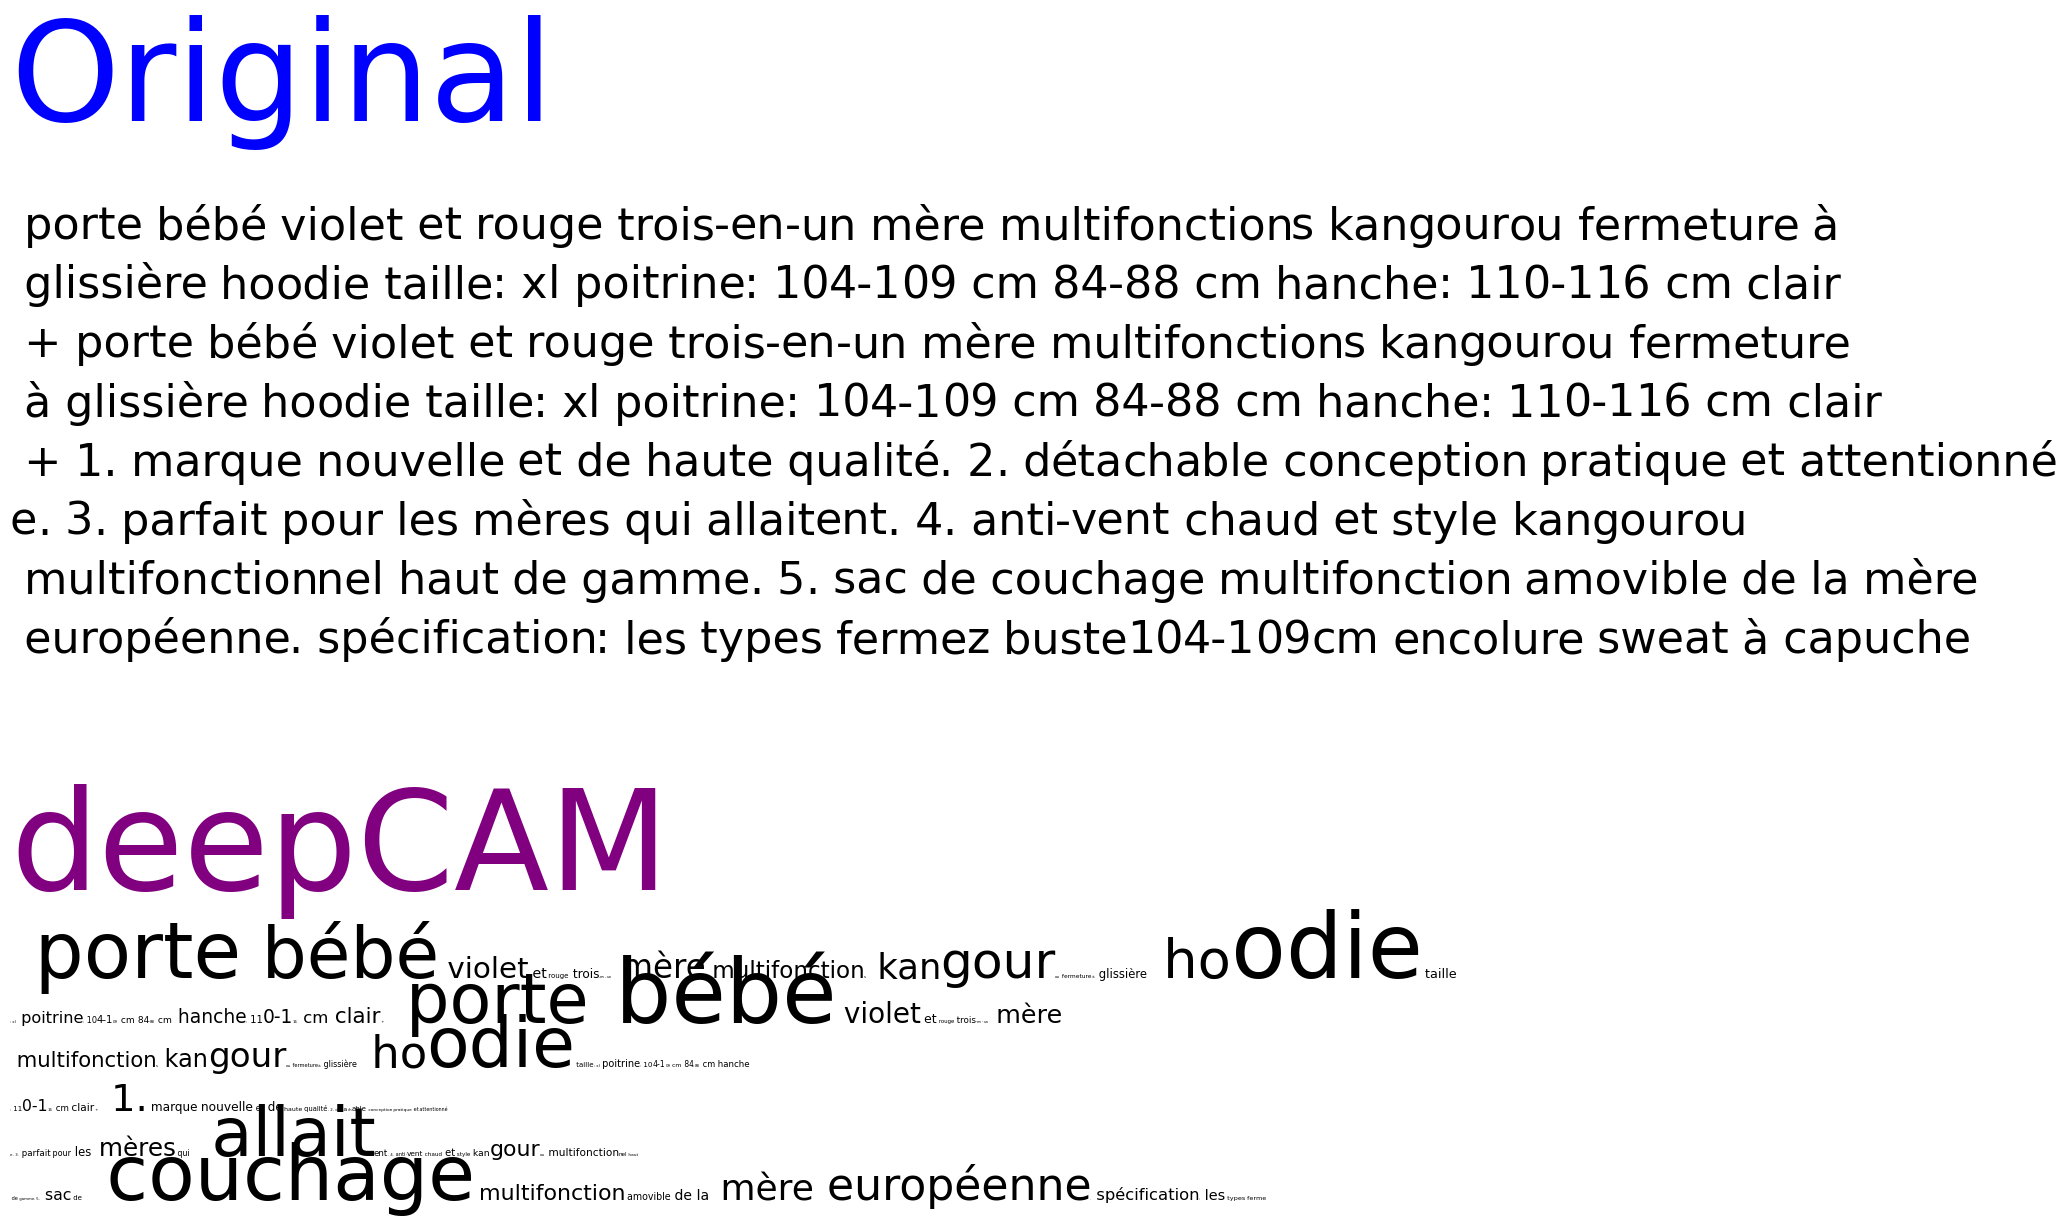

In [30]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2)
ax[0].imshow(icam.image);
ax[0].axis('off')
ax[0].set_title('original')
ax[1].imshow(icam.image_masked);
ax[1].axis('off')
ax[1].set_title('deepCAM')

plt.show()

fig, ax = plt.subplots()
plot_weighted_text(0, 0.7, icam.text, icam.text_masked*0+0.4, base_font_size=80, char_per_line=80, title='Original', title_color='blue', title_fontsize=100, ax=ax)
plot_weighted_text(0, ax.get_ylim()[0], icam.text, icam.text_masked*5, base_font_size=60, char_per_line=100, title='deepCAM', title_color='purple', title_fontsize=100, ax=ax)
plt.show()

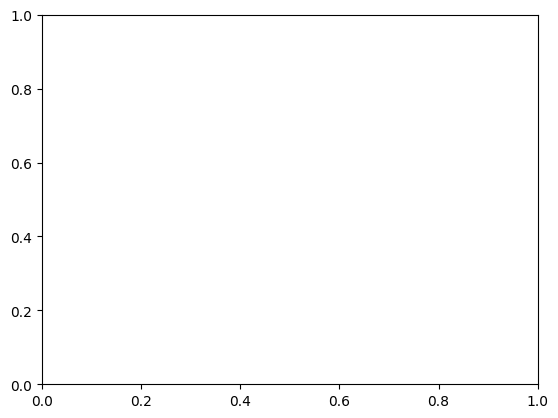

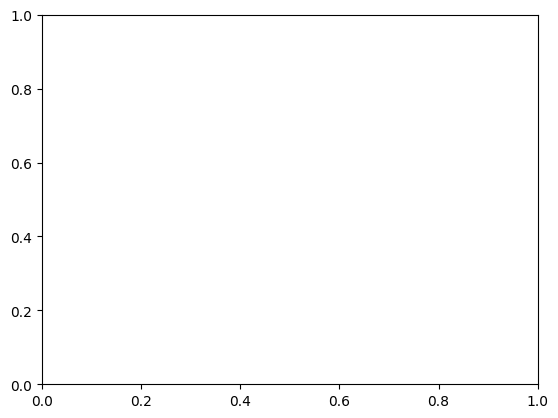

In [149]:

fig, ax = plt.subplots()
plot_weighted_text(0, 0, icam.text, icam.text_masked*0+icam.text_masked.mean(), base_font_size=100, words_per_line=20, ax=axs)
plt.show();
fig, ax = plt.subplots()
plot_weighted_text(0, 0, icam.text, icam.text_masked, base_font_size=100, words_per_line=40, ax=axs)
plt.show();

All model checkpoint layers were used when initializing TFCamembertModel.

All the layers of TFCamembertModel were initialized from the model checkpoint at /mnt/c/Users/justj/Documents/DST/RakutenProject/models/base_models/camembert-base-ccnet.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertModel for predictions without further training.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


AttributeError: 'deepCAM' object has no attribute 'image'

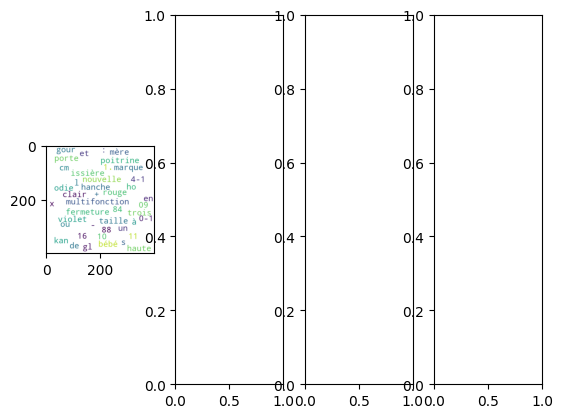

In [56]:
import matplotlib.pyplot as plt

icam = deepCAM(clf_bert)

for txt_idx in range(3):
    masked_image, masked_text = icam.getMaskedInput(data['tokens'][txt_idx], min_factor=0.0)
    
    fig, ax = plt.subplots(1, 4)

    ax[0].imshow(icam.text)
    ax[1].imshow(icam.image)
    ax[2].imshow(masked_text)
    ax[3].imshow(masked_image)

In [10]:
from transformers import TFAutoModel, AutoTokenizer, CamembertConfig, CamembertTokenizer, FlaubertTokenizer

base_model_path = os.path.join(config.path_to_models, 'base_models', 'camembert-base')
bert_config = CamembertConfig.from_pretrained('camembert-base', output_attentions=True, output_hidden_states=False)
base_model = TFAutoModel.from_pretrained(base_model_path, config=bert_config)
tokenizer = CamembertTokenizer.from_pretrained(base_model_path)

All model checkpoint layers were used when initializing TFCamembertModel.

All the layers of TFCamembertModel were initialized from the model checkpoint at /mnt/c/Users/justj/Documents/DST/RakutenProject/models/base_models/camembert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertModel for predictions without further training.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [11]:
seq_length = 52
X = tokenizer(data['tokens'][0], padding="max_length", truncation=True, max_length=seq_length, return_tensors="tf")
outputs = base_model(X)

In [32]:
seq_length = 52
outputs = base_model(X)
num_layers = len(outputs.attentions)
for k in range(num_layers):
    weights = outputs.attentions[k].numpy()
    num_heads = weights.shape[1]
    weights = weights.reshape((1, num_heads, seq_length, seq_length))
    if k == 0:
        reshaped = weights
    else:
        reshaped = np.concatenate([reshaped, weights], axis=0)
        
reshaped = reshaped.mean(axis=1)

# From Section 3 in https://arxiv.org/pdf/2005.00928.pdf ...
# To account for residual connections, we add an identity matrix to the
# attention matrix and re-normalize the weights.
reshaped = reshaped + np.eye(reshaped.shape[1])
reshaped = reshaped / reshaped.sum(axis=(1, 2))[:, np.newaxis, np.newaxis]

In [62]:
v = reshaped[-1]
for n in range(1, len(reshaped)):
    v = np.matmul(v, reshaped[-1 - n])

# Attention from the output token to the input space.
mask = v[0, 1:]
mask = (mask / mask.max())

In [36]:
allwords = tokenizer.convert_ids_to_tokens(X['input_ids'][0][1:-1])
''.join([word.replace('▁',' ') for word in allwords])
plt.text()

' porte bébé violet et rouge trois-en-un mère multifonctions kangourou fermeture à glissière hoodie taille: xl poitrine: 104-109 cm 84-88 cm hanche: 110-116 cm clair + porte bébé violet et rouge trois-'

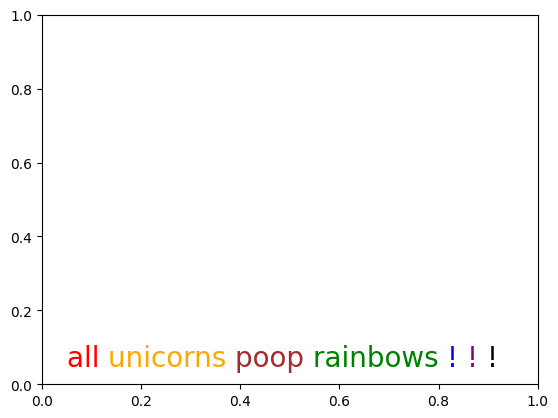

In [50]:
import matplotlib.pyplot as plt
from matplotlib import transforms

def rainbow_text(x,y,ls,lc,**kw):
    """
    Take a list of strings ``ls`` and colors ``lc`` and place them next to each
    other, with text ls[i] being shown in color lc[i].

    This example shows how to do both vertical and horizontal text, and will
    pass all keyword arguments to plt.text, so you can set the font size,
    family, etc.
    """
    t = plt.gca().transData
    fig = plt.gcf()
    
    #horizontal version
    for s,c in zip(ls,lc):
        text = plt.text(x,y,s+" ",color=c, transform=t, **kw);
        text.draw(fig.canvas.get_renderer())
        ex = text.get_window_extent()
        if ex.width < 200:
            t = transforms.offset_copy(text._transform, x=ex.width, units='dots')
        else:
            t = transforms.offset_copy(text._transform, y=ex.height, units='dots')


plt.figure()
rainbow_text(0.05,0.05,"all unicorns poop rainbows ! ! !".split(), 
        ['red', 'orange', 'brown', 'green', 'blue', 'purple', 'black'],
        size=20);

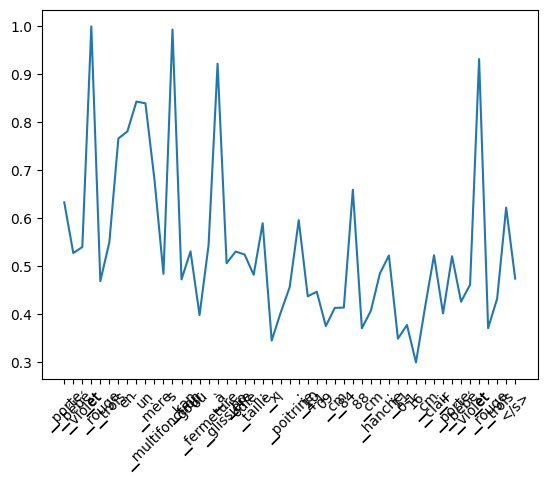

In [66]:
import matplotlib.pyplot as plt

plt.plot(mask)
plt.xticks(range(len(mask)), tokenizer.convert_ids_to_tokens(X['input_ids'][0][1:]), rotation=45)

plt.show()

In [71]:
word_bert

{'▁porte': 0.5200863360920243,
 '▁bébé': 0.4252571222634755,
 '▁violet': 0.46070541023278905,
 '▁et': 0.9317386750408004,
 '▁rouge': 0.36992634734861146,
 '▁trois': 0.43145771343559963,
 '-': 0.6217132864478644,
 'en': 0.7807130704047658,
 'un': 0.8393887319257779,
 '▁mère': 0.6804892687322598,
 '▁multifonction': 0.48326143529580295,
 's': 0.9935213392619114,
 '▁kan': 0.4716886540973536,
 'gour': 0.5302046010833187,
 'ou': 0.3972769536214474,
 '▁fermeture': 0.5429911250448348,
 '▁à': 0.9221768826115319,
 '▁glissière': 0.5055087701016004,
 '▁ho': 0.5298705082811705,
 'odie': 0.5236733285192698,
 '▁taille': 0.4812788783322131,
 ':': 0.5216956069374946,
 '▁x': 0.3440309631022496,
 'l': 0.4024391855590966,
 '▁poitrine': 0.45590308097379795,
 '▁10': 0.4364670133018938,
 '4-1': 0.4460613953692592,
 '09': 0.3742942275015823,
 '▁cm': 0.41284038419318597,
 '▁84': 0.41288936769709705,
 '88': 0.36964310773584524,
 '▁hanche': 0.48407162262130143,
 '▁11': 0.34800889342287594,
 '0-1': 0.376488223290

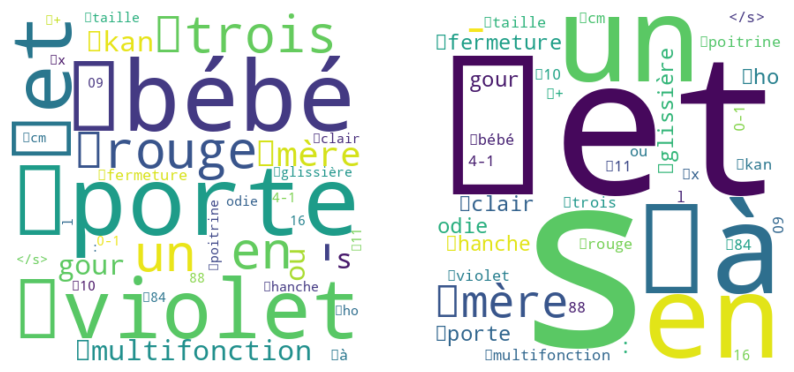

In [73]:
from wordcloud import WordCloud
allwords = tokenizer.convert_ids_to_tokens(X['input_ids'][0][1:])

word_orig = {word: 1 for word in allwords}
word_bert = {word: mask[idx] for idx, word in enumerate(allwords)}

wordcloud_orig = WordCloud(width=400, height=400, background_color ='white').generate_from_frequencies(word_orig)
wordcloud_bert = WordCloud(width=400, height=400, background_color ='white').generate_from_frequencies(word_bert)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_orig, interpolation='bilinear')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_bert, interpolation='bilinear')
plt.axis('off')

plt.show()

In [121]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
import tensorflow as tf

import numpy as np
import pandas as pd
import cv2

from vit_keras import vit, utils, visualize, layers
from transformers import TFAutoModel, AutoTokenizer, CamembertTokenizer, CamembertModel, FlaubertTokenizer, CamembertConfig
from wordcloud import WordCloud

import os
import sys

import config

from src.text.classifiers import TFbertClassifier
from src.image.classifiers import ImgClassifier
from src.multimodal.classifiers import TFmultiClassifier

class deepCAM:
    def __init__(self, classifier):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.classifier = classifier
        self.img_base_name = 'None'
        self.txt_base_name = 'None'
        self.preprocessing_function_img = None
        self.preprocessing_function_txt = None
        self.decode_function_txt = None
        self.img_size = None
        
        if isinstance(classifier, ImgClassifier):
            self.preprocessing_function_img = classifier.preprocessing_function
            self.img_size = classifier.img_size
            self.img_base_name = classifier.base_name
        elif isinstance(classifier, TFbertClassifier):
            self.txt_base_name = classifier.base_name
        elif isinstance(classifier, TFmultiClassifier):
            self.preprocessing_function_img = classifier.preprocessing_function
            self.img_size = classifier.img_size
            self.txt_base_name = classifier.txt_base_name
            self.img_base_name = classifier.img_base_name
        
        if 'resnet' in self.img_base_name.lower():
            x = classifier.model.get_layer('img_base_layers')(classifier.model.inputs)
            lastconv_outputs = Dropout(rate=0, name='dummy_layer')(x)
            x = lastconv_outputs
            
            is_top_layer = False
            for layer in classifier.model.layers:
                if is_top_layer:
                    x = layer(x)
                elif layer.name == 'img_base_layers':
                    is_top_layer = True
                    
            outputs = x

            self.gradModel_img = Model(
                        inputs=[classifier.model.inputs],
                        outputs=[lastconv_outputs, outputs])
            
        if 'vit' in self.img_base_name.lower():
            self.gradModel_img = vit.vit_b16(image_size=classifier.img_size[0:2], pretrained=True, include_top=False, pretrained_top=False)
            for grad_layer, orig_layer in zip(self.gradModel_img.layers[:-2], classifier.model.get_layer('img_base_layers').layers):
                grad_layer.set_weights(orig_layer.weights)
                
        if 'bert' in self.txt_base_name.lower():
            base_model_path = os.path.join(config.path_to_models, 'base_models', self.txt_base_name)
            if 'camembert' in self.txt_base_name.lower():
                bert_config = CamembertConfig.from_pretrained('camembert-base', output_attentions=True, output_hidden_states=False)
                base_model = TFAutoModel.from_pretrained(base_model_path, config=bert_config)
                tokenizer = CamembertTokenizer.from_pretrained(base_model_path)
            elif 'flaubert' in self.txt_base_name.lower():
                base_model = TFAutoModel.from_pretrained(base_model_path)
                tokenizer = FlaubertTokenizer.from_pretrained(
                    'flaubert/flaubert_base_uncased')
                
            self.preprocessing_function_txt = lambda x: tokenizer(x, padding="max_length", truncation=True, max_length=classifier.max_length, return_tensors="tf")
            self.decode_function_txt = lambda x: tokenizer.convert_ids_to_tokens(x)
            self.gradModel_txt = base_model
            for grad_layer, orig_layer in zip(self.gradModel_txt.layers[0].encoder.layer, classifier.model.get_layer('txt_base_layers').layers[0].encoder.layer):
                grad_layer.set_weights(orig_layer.weights)
          
          
          
                
    def grad_map(self, image, min_factor=0.0):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        
        image_orig = cv2.resize(image, self.img_size[:2])
        image = self.preprocessing_function_img(image_orig)
        image = image.reshape((1,) + image.shape)
        
        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            tape.watch(inputs)
            # Ensure this call is within the tape context to track operations
            (convOutputs, predictions) = self.gradModel_img(inputs)
            tape.watch(convOutputs)
            # Assuming your model's final layer uses a softmax activation
            class_idx = tf.argmax(predictions[0])
            loss = predictions[:, class_idx]

        # Now, compute the gradients of the loss w.r.t the convOutputs
        grads = tape.gradient(loss, convOutputs)
        
        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        mask = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        eps=1e-8
        mask = (mask - np.min(mask)) / ((mask.max() - mask.min()) + eps)
        mask = np.tile(np.expand_dims(mask, axis=2), (1, 1, 3))
        
        # save mask, original image and image overlaid with mask
        self.mask_img = mask
        self.image = image_orig
        mask[mask < min_factor] = min_factor
        self.image_masked = (mask * self.image).astype("uint8")
        
        return self.image_masked
    
    
    
    def attention_map_img(self, image, min_factor=0.0):
        img_height, img_width = self.gradModel_img.input_shape[1], self.gradModel_img.input_shape[2]
        grid_size = int(np.sqrt(self.gradModel_img.layers[5].output_shape[0][-2] - 1))

        # Prepare the input
        image_orig = cv2.resize(image, (img_height, img_width))
        X = self.preprocessing_function_img(image_orig)[np.newaxis, :]

        # Get the attention weights from each transformer.
        outputs = [layer.output[1] for layer in self.gradModel_img.layers if isinstance(layer, layers.TransformerBlock)]
        weights = np.array(tf.keras.models.Model(inputs=self.gradModel_img.inputs, outputs=outputs).predict(X))
        num_layers = weights.shape[0]
        num_heads = weights.shape[2]
        reshaped = weights.reshape((num_layers, num_heads, grid_size**2 + 1, grid_size**2 + 1))

        # From Appendix D.6 in the paper ...
        # Average the attention weights across all heads.
        reshaped = reshaped.mean(axis=1)

        # From Section 3 in https://arxiv.org/pdf/2005.00928.pdf ...
        # To account for residual connections, we add an identity matrix to the
        # attention matrix and re-normalize the weights.
        reshaped = reshaped + np.eye(reshaped.shape[1])
        reshaped = reshaped / reshaped.sum(axis=(1, 2))[:, np.newaxis, np.newaxis]

        # Recursively multiply the weight matrices
        v = reshaped[-1]
        for n in range(1, len(reshaped)):
            v = np.matmul(v, reshaped[-1 - n])

        # Attention from the output token to the input space.
        mask = v[0, 1:].reshape(grid_size, grid_size)
        mask = (mask / mask.max())
        mask = np.tile(np.expand_dims(mask, axis=2), (1, 1, 3))
        mask = cv2.resize(mask, image_orig.shape[:2], interpolation = cv2.INTER_LINEAR)
        
        self.mask_img = mask
        self.image = image_orig
        mask[mask < min_factor] = min_factor
        self.image_masked = (mask * self.image).astype("uint8")
        
        return self.image_masked
    
    def attention_map_txt(self, text, min_factor=0.0):
        # Prepare the input
        X = self.preprocessing_function_txt(text)
        seq_length = X['input_ids'].shape[1]
        
        # Get the attention weights from each transformer.
        outputs = self.gradModel_txt(X)
        num_layers = len(outputs.attentions)
        for k in range(num_layers):
            weights = outputs.attentions[k].numpy()
            num_heads = weights.shape[1]
            weights = weights.reshape((1, num_heads, seq_length, seq_length))
            if k == 0:
                reshaped = weights
            else:
                reshaped = np.concatenate([reshaped, weights], axis=0)

        # From Appendix D.6 in the paper ...
        # Average the attention weights across all heads.
        reshaped = reshaped.mean(axis=1)

        # From Section 3 in https://arxiv.org/pdf/2005.00928.pdf ...
        # To account for residual connections, we add an identity matrix to the
        # attention matrix and re-normalize the weights.
        reshaped = reshaped + np.eye(reshaped.shape[1])
        reshaped = reshaped / reshaped.sum(axis=(1, 2))[:, np.newaxis, np.newaxis]

        # Recursively multiply the weight matrices
        v = reshaped[-1]
        # for n in range(1, len(reshaped)):
        #     v = np.matmul(v, reshaped[-1 - n])

        # Attention from the output token to the input space.
        mask = v[0, 1:]
        valid_mask_idx = np.argwhere(mask > 0)
        valid_mask_idx = np.squeeze(valid_mask_idx).tolist()
        valid_mask_idx.pop(-1)
        mask = (mask[valid_mask_idx] / mask[valid_mask_idx].max())
        self.mask_txt = mask
        
        base_font_size = 10
        allwords = self.decode_function_txt(X['input_ids'][0][1:])
        allwords = [word for idx, word in enumerate(allwords) if idx in valid_mask_idx]
        word_length = np.array([len(word) for word in allwords])
        min_mask = self.mask_txt[word_length < 3].min()
        self.mask_txt[word_length < 3] = min_mask
        word_orig = [word.replace('▁', ' ') for word in allwords]
        # word_bert = [word.replace('▁', ' ') for word in enumerate(allwords)]

        self.text = word_orig
        self.text_masked = self.mask_txt
        
        return self.text_masked
    
    
    
    def getMaskedInput(self, X, min_factor=0.0):
        image_masked = None
        text_masked = None
        
        if isinstance(X, dict):
            X_img = X['image']
            X_txt = X['text']
        elif isinstance(X, np.ndarray):
            X_img = X
            X_txt = None
        else:
            X_img = None
            X_txt = X
            
        if 'resnet' in self.img_base_name.lower() and X_img is not None:
            image_masked = self.grad_map(X_img, min_factor)
        if 'vit' in self.img_base_name.lower() and X_img is not None:
            image_masked = self.attention_map_img(X_img, min_factor)
        if 'bert' in self.txt_base_name.lower() and X_txt is not None:
            text_masked = self.attention_map_txt(X_txt, min_factor)
            
        return image_masked, text_masked

In [310]:
def plot_weighted_text(x, y, words, weights, base_font_size=10, ax=None, char_per_line=10, title='None', title_color='purple', title_fontsize=100, **kw):
    """
    Display words with font sizes adjusted according to a list of weights without using LaTeX.
    Each word in `words` will have a font size that is the base font size multiplied by its corresponding weight in `weights`.
    
    :param x: The x-coordinate for the start of the text.
    :param y: The y-coordinate for the start of the text.
    :param words: A list of words to display.
    :param weights: A list of weights corresponding to each word. These weights are used to adjust the font size.
    :param base_font_size: The base font size that is adjusted by the weights.
    """
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure
    
    lines = [[title]]
    weight_segments = [[1/base_font_size * title_fontsize]]
    
    word_line = []
    weight_line = []
    char_length = 0
    for word, weight in zip(words, weights):
        word_line.append(word)
        weight_line.append(weight)
        char_length += len(word)
        if char_length > char_per_line:
            lines.append(word_line)
            weight_segments.append(weight_line)
            char_length = 0
            word_line = []
            weight_line = []
        
    first_line = True
    color = title_color
    current_y = y
    for line, weight_segment in zip(lines, weight_segments):
        current_x = x
        for word, weight in zip(line, weight_segment):
            # Calculate font size based on weight
            font_size = base_font_size * weight
            # Display each word with the adjusted font size
            text_handle = plt.text(current_x, current_y, word, fontsize=font_size, color=color, transform=ax.transAxes, **kw)
            # Measure the text size to adjust the next word's position
            text_extent = text_handle.get_window_extent()
            current_x += 0.2*text_extent.width / fig.dpi  # Adjust for next word position
        if first_line:
            current_y -= (0.4*base_font_size / fig.dpi)  # Move to next line
            first_line = False
            color = 'black'
        else:
            current_y -= (0.2*base_font_size / fig.dpi)  # Move to next line

    current_y -= (0.6*base_font_size / fig.dpi)
    
    ax.axis('off');
    ax.set_xlim(0, 1);
    ax.set_ylim(current_y, y);


In [311]:
icam.text_masked.mean()*100

3.0855908486742774

(-2.8800000000000003, -1.56)


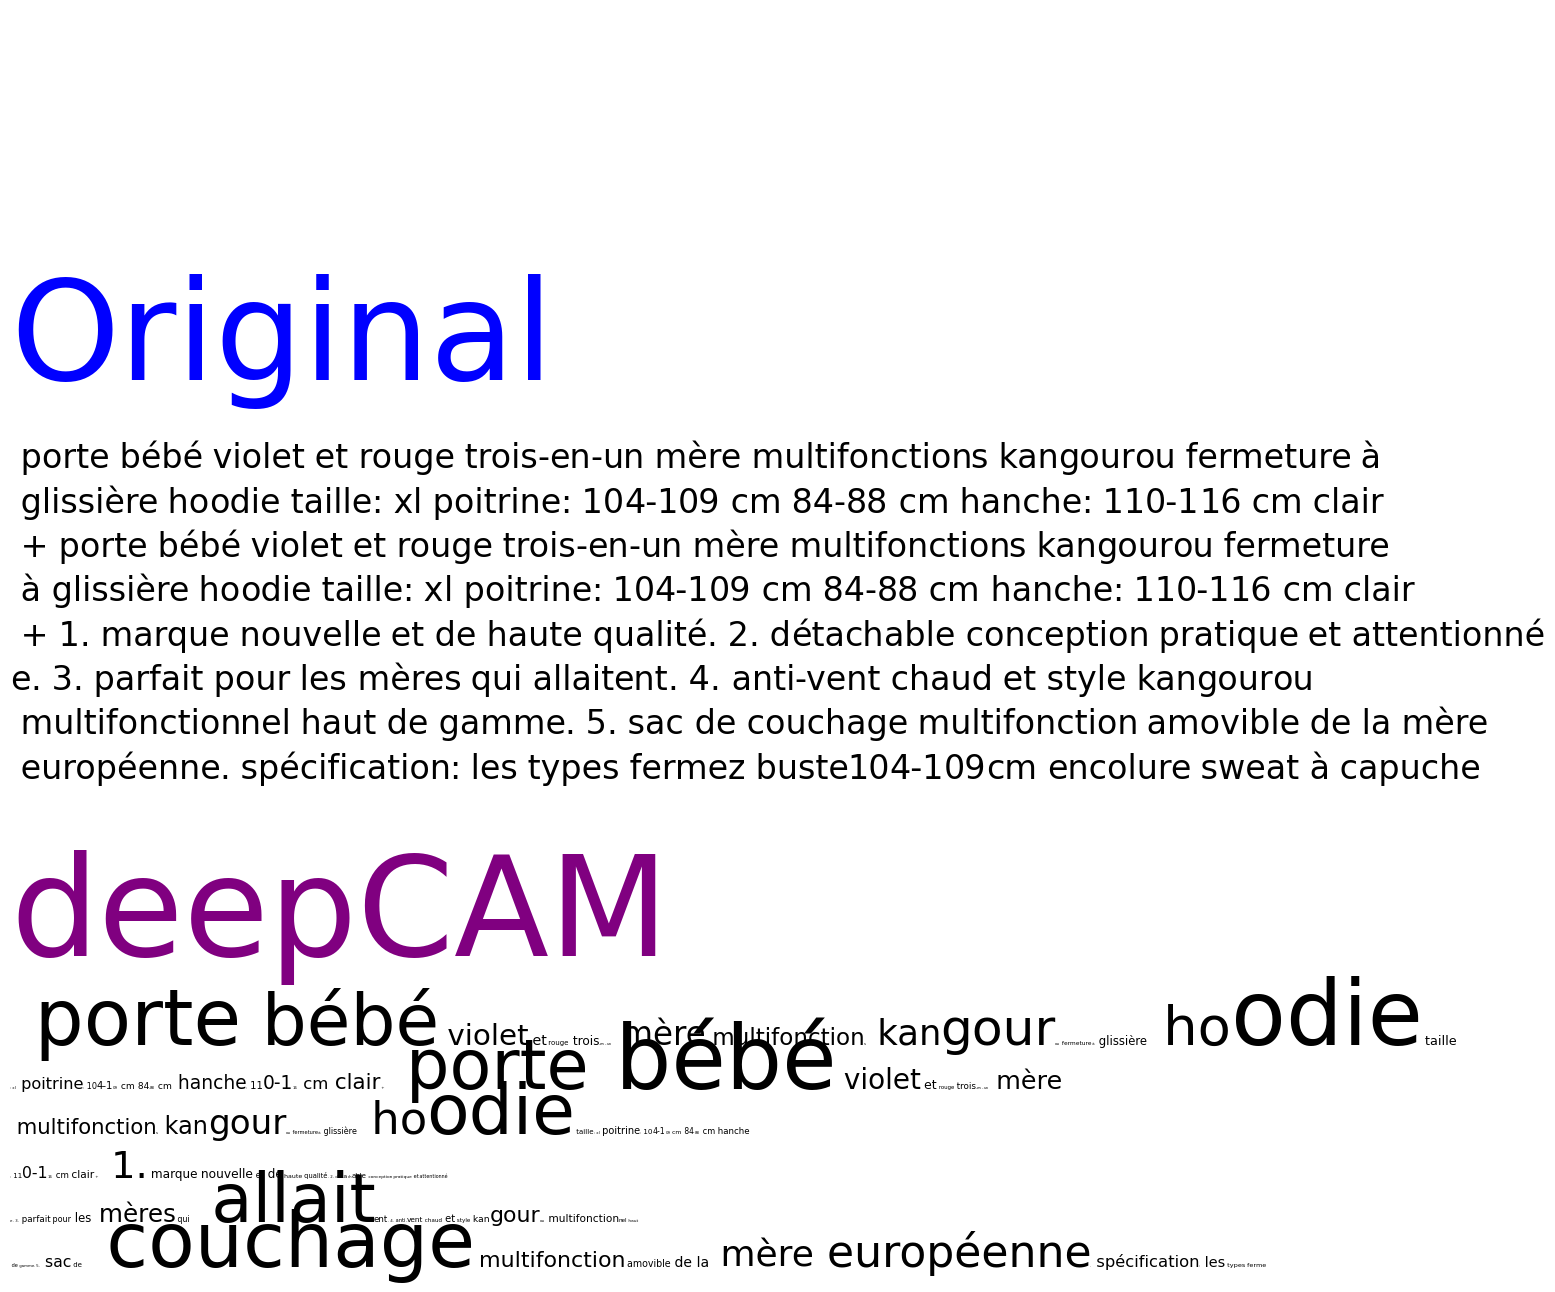

In [312]:

fig, ax = plt.subplots()
plot_weighted_text(0, 0, icam.text, icam.text_masked*0+0.4, base_font_size=60, char_per_line=80, title='Original', title_color='blue', title_fontsize=100, ax=ax)
plot_weighted_text(0, ax.get_ylim()[0], icam.text, icam.text_masked*5, base_font_size=60, char_per_line=100, title='deepCAM', title_color='purple', title_fontsize=100, ax=ax)
print(ax.get_ylim())
plt.show();